# Primary Grid to Dualgrid Conversion

## To Do:
- Primary grid must be stored as tuple list 
- Only pointers in dualgrid functions!


## Interior Dualgrid:
Each dualgrid cell is stored as list array. Dualcell loop starts always with adjacent primary element with lowest x- and y-values.
The loop moves from this element centroid to the centroid of an adjacent edge to the next element centroid and so on.
If a node has $N$ adjacent elements, there will be $N$ element centroids and $N$ edge centroids  in the dualcell list. So the loop ends, if len(duallist) equals $2N$.

    1) Start at interior node $i$

    2) Move to adjacent element with lowest x- and y-values and append element to dualcell list.

    3) Grab the edges of this element, that are adjacent to node $i$ and add the edge, that is not yet in the current dualcell list. If none of these edges is already part of the current dualcell list, append the one with the lowest x- and y-centroid.

    4) Move to the adjacent element of this edge.

In [36]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np




        

def get_edge_to_triangle_connection(T):
    '''
    Function to determine the neighbouring elements of an edge in a triangular mesh
    
    Input:
        T: 3 x N dimensional list with triangle node indices for mesh with N 
           triangles
    Output:
        edges: dictionary - keys are two node indices, that define a triangles edge
               every key has a list of two values, which are the adjacent triangles 
               to the edge. If the last value is -1, the edge is located at the boundary
               
    '''
    E2T = {}
    # Loop over all triangles
    for iTri, tri in enumerate(T):
        # Loop over all current edges
        for iE in range(3):
            edge = (tri[iE], tri[(iE+1)%3])
            
            # Check if edge is already in dictionary
            if (edge in E2T) or (edge[::-1] in E2T):
                try:
                    E2T[edge][1] = tuple(tri)#iTri
                except:
                    E2T[edge[::-1]][1] = tuple(tri) #iTri
            else:
                E2T.update({edge:[tuple(tri), -1]})
    return E2T
            
    
def get_node_to_triangle_connection(T):
    '''
    Function to determine the triangles, that are adjacent to a node in the triangular mesh.
    
    Input:
        T: 3 x N dimensional list with triangle node indices for mesh with N 
           triangles
    Output:
        nodes: dictionary - keys are the mesh nodes - their values are the indices of their
               adjacent triangular elements

    '''
    nodes = {}
    # Loop over all triangles
    for iTri, tri in enumerate(T):
        # Loop over all triangle nodes
        for n in tri:
            if n in nodes:
                nodes[n].append(tuple(tri))
            else:
                nodes.update({n: [tuple(tri)]})
    return nodes
            
            
def get_node_to_edge_connection(E2T):
    '''
    Function determines which edges are adjacent to the mesh nodes
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output:
        nodes: dictionary - keys are the mesh nodes - their values are the indices of their
               adjacent mesh-edges
    
    '''
    nodes = {}
    # Loop over all edges
    for edg in E2T:
        # Loop over all nodes of the respective edge
        for n in edg:
            if n in nodes:
                nodes[n].append(edg)
            else:
                nodes.update({n: [edg]})
    return nodes


def get_triangle_to_triangle_connection(E2T):
    '''
    This function creates the connectivity between triangular elements
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output: T2T - dictionary - keys are the triangles in node connectivity format
            and values are a list with three entries, that have the neighbouring
            triangle node connectivities or -1 if that edge is at the boundary
    '''
    T2T = {}
    for edg in E2T:
        # Get the triangles that are already found, in "set()" format
        keys = [set(k) for k in T2T.keys()]
        # Check both adjacent triangles to current face 
        for itri, tri in enumerate(E2T[edg]):
            # Boundary edges will have set -1 as second triangle
            if (tri == -1):
                continue   
            # check if triangle exists - if not, add triangle to T2T
            if set(tri) not in keys:
                T2T.update({tri: [-1, -1, -1]})    
            # Check, which indice "edg" has in the current triangle
            # This triangle will then get the neighbor triangle at the
            # same position in the T2T-list
            indEdg = 0
            for iE in range(3):
                edgTri = set((tri[iE], tri[(iE+1)%3]))
                if (set(edg) == edgTri):
                    T2T[tri][indEdg] = E2T[edg][(itri+1)%2]
                indEdg += 1  
    return T2T
        

def get_boundary_nodes(E2T):
    '''
    This function determines, which nodes are located at the boundary
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output: list of node indices, that are adjacent to a boundary
    '''
    nodes = []
    for edg in E2T:
        if E2T[edg][1] == -1:
            nodes.append(edg[0])
    return nodes


def get_interior_nodes(bdry_nodes, N):
    '''
    This function determines, which nodes are located in the interior of the domain
    
    Input: bdry_nodes - list with indices of nodes that are adjacent to a boundary
           N - length of global node array
    
    Output: list of node indices, that are not adjacent to a boundary
    '''
    nodes = []
    for i in range(N):
        if i not in bdry_nodes:
            nodes.append(i)
    return nodes


def eval_edge_centroid(x, y, edge):
    '''
    This function computes the centroid of an edge (i0,i1)
    '''
    xc, yc = 0.0, 0.0
    for i in range(2):
        xc += x[triangle[i]]
        yc += y[triangle[i]]
    return ((xc/2.0, yc/2.0))

def eval_triangle_centroid(x, y, triangle):
    '''
    This function computes the centroid of a triangle (i0,i1,i2)
    '''
    xc, yc = 0.0, 0.0
    for i in range(3):
        xc += x[triangle[i]]
        yc += y[triangle[i]]
    return ((xc/3.0, yc/3.0))
    

def get_dual_median_cell(iNode, x, y, N2T, N2E, E2T):
    '''
    This function creates the dual-median connetivity list around a node "iNode"
    '''
    # The dualcell-list
    dualcell = []
    
    # Collect all edges that are adjacent to this node
    adjEdge = N2E[iNode]
    
    # Collect all triangles that are adjacent to this node
    adjTri = N2T[iNode]
    
    # Create set array of adjacent edges
    adjEdge_keys = [set(edg) for edg in adjEdge]
    
    # Number of adjacent elements
    N = len(adjTri)
    
    # Start with first triangle in "adTri" 
    dualcell.append(adjTri[0])
    
    # Perform the dualcell loop
    maxIter = 0
    
    # Create array of keys with already appended elements / edges
    dualkeys = [set(dc) for dc in dualcell]
        
    while (len(dualcell) < 2*N) and (maxIter < 3*N):
        maxIter += 1
        for iEdge in range(3):
            edge = set(( dualcell[-1][iEdge], dualcell[-1][(iEdge+1)%3] ))
            # Check if this edge is part of the adjacend edges to node 
            # and if this edge has already been appended to dualcell list
            if (edge not in dualkeys) and (edge in adjEdge_keys):
                # Find current edge in "adjEdge" list
                for adEdge in adjEdge:
                    if (edge == set(adEdge)):
                        # Find adjacent triangle to this edge, that is not the
                        # current triangle
                        if (set(dualcell[-1]) == set(E2T[adEdge][0])):
                            nextElem = E2T[adEdge][1]
                        else:
                            nextElem = E2T[adEdge][0]
                        dualcell.append(adEdge)
                        # Add new keys
                        dualkeys.append(set(dualcell[-1]))
                        if (len(dualcell)<2*N):
                            dualcell.append(nextElem)
                            # Add new keys
                            dualkeys.append(set(dualcell[-1]))
                        continue
                        
                if (len(dualcell)>= 2*N):
                    break
    return dualcell
    
    
        


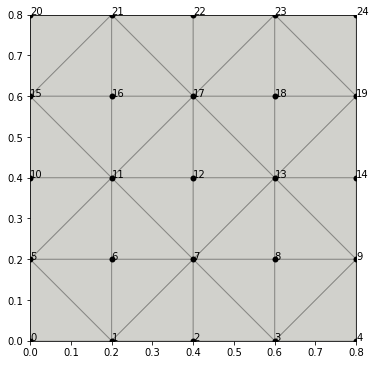

[(11, 7, 12),
 (7, 12),
 (12, 7, 13),
 (13, 12),
 (12, 13, 17),
 (12, 17),
 (17, 11, 12),
 (12, 11)]

In [42]:

x0 = (0, 1)
y0 = (0, 1)
h = 0.20
Nx = int((x0[1]-x0[0])/h)
Ny = int((x0[1]-x0[0])/h)

x = [x0[0] + i*h for j in range(Nx) for i in range(Ny)]
y = [y0[0] + j*h for j in range(Nx) for i in range(Ny)]

# Create triangular mesh
#------------------------------------------------------
T = Triangulation(x, y)
E2T = get_edge_to_triangle_connection(T.triangles)
N2T = get_node_to_triangle_connection(T.triangles)
N2E = get_node_to_edge_connection(E2T)
T2T = get_triangle_to_triangle_connection(E2T)
bdry_nodes = get_boundary_nodes(E2T)
intr_nodes = get_interior_nodes(bdry_nodes, len(x))


fig = plt.figure()
fig.set_size_inches(6,6)
ax = fig.add_subplot(111)
ax.set_aspect('equal')

tri_patches = []
for tri in T.triangles:
    poly = Polygon([[x[iNode], y[iNode]] for iNode in tri])
    tri_patches.append(poly)
    
for i in range(len(x)):
    #if(i in intr_nodes):
    ax.plot(x[i], y[i], marker='o', mfc='k',mec='None')
    ax.text(x[i], y[i], str(i))
    
    
ax.set_xlim([0,.8])
ax.set_ylim([0,.8])
tri_patchCol = PatchCollection(tri_patches, alpha=0.2, facecolor=[.1,.1,.0], edgecolor='k')
ax.add_collection(tri_patchCol)
plt.show()

iNode = 12
#create_dual_median_volume(iNode, N2T, N2E, E2T)
get_dual_median_cell(iNode, x, y, N2T, N2E, E2T)

[0 1 4]
[(0, 1, 4), (5, 1, 2), (9, 4, 5)]
[1 2 3]
[(0, 1, 4), (5, 1, 2), (9, 4, 5)]


In [30]:
N2E

{4: [(4, 1), (5, 4), (4, 0), (9, 4), (8, 4)],
 1: [(4, 1), (1, 5), (0, 1), (1, 2)],
 5: [(1, 5), (5, 4), (2, 5), (6, 5), (5, 9), (10, 5)],
 0: [(0, 1), (4, 0)],
 3: [(3, 7), (2, 3)],
 7: [(3, 7), (7, 2), (7, 6), (7, 10), (7, 11)],
 2: [(7, 2), (2, 3), (6, 2), (1, 2), (2, 5)],
 6: [(7, 6), (6, 2), (6, 5), (6, 10)],
 9: [(9, 4), (5, 9), (9, 8), (9, 13), (10, 9), (9, 14)],
 8: [(9, 8), (8, 4), (12, 8), (8, 13)],
 12: [(12, 8), (13, 12)],
 13: [(8, 13), (13, 12), (9, 13), (14, 13)],
 10: [(6, 10), (10, 5), (10, 9), (7, 10), (11, 10), (14, 10)],
 11: [(7, 11), (11, 10), (14, 11), (11, 15)],
 14: [(14, 11), (15, 14), (14, 10), (14, 13), (9, 14)],
 15: [(11, 15), (15, 14)]}